In [30]:
import warnings

In [3]:
pip install --upgrade category_encoders

     ---------------------------------------- 81.9/81.9 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [20]:
# Import libraries here
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
import matplotlib.pyplot as plt

In [5]:
# Build your `wrangle` function
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)
    
    # Subset data: Apartments in "Distrito Federal", less than 100,000
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_ba & mask_apt & mask_price]
    
    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)

    #Drop features with high null counts
    df.drop(columns=["floor", "expenses", "rooms", "surface_total_in_m2", "price_usd_per_m2"], inplace=True)
    
    #Drop low- and high-cardinality categorical variables
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)
    
    # Drop leaky columns
    df.drop(
       columns=[
        'price',
        'price_aprox_local_currency',
        'price_per_m2',
       ], 
       inplace=True
    )
    
    return df

In [6]:
df = wrangle(r"C:\Users\ayanm\OneDrive\Desktop\Jupytar Notebook\mexico-city-real-estate-1.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1101 entries, 11 to 4605
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        1101 non-null   float64
 1   surface_covered_in_m2  1101 non-null   float64
 2   lat                    1041 non-null   float64
 3   lon                    1041 non-null   float64
 4   borough                1101 non-null   object 
dtypes: float64(4), object(1)
memory usage: 51.6+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


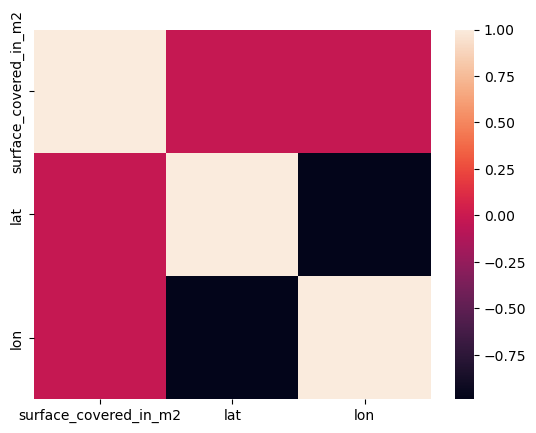

In [13]:
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
sns.heatmap(corr);

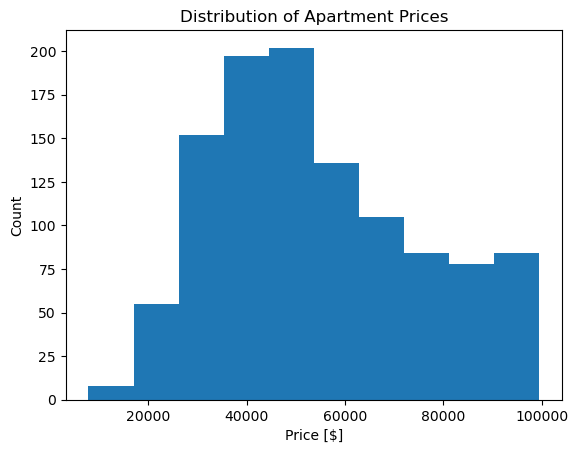

In [12]:
# Build histogram
plt.hist(df["price_aprox_usd"])


# Label axes
plt.xlabel("Price [$]")
plt.ylabel("Count")

# Add title
plt.title("Distribution of Apartment Prices");

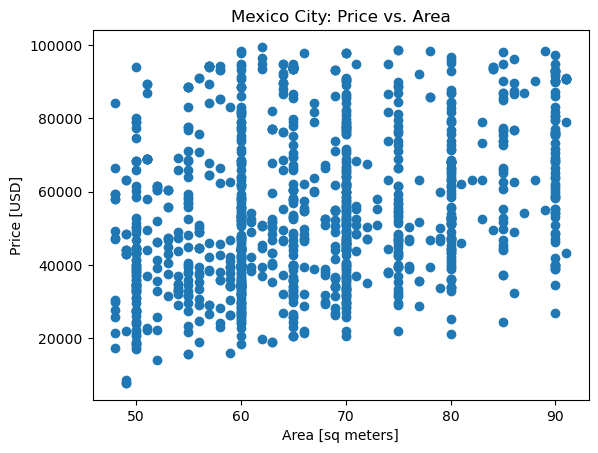

In [11]:
# Build scatter plot
plt.scatter(x=df["surface_covered_in_m2"], y=df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Mexico City: Price vs. Area");

In [19]:
# Split data into feature matrix `X` and target vector `y`.
features = ["surface_covered_in_m2", "lat", "lon", "borough"]
target = "price_aprox_usd"
X = df[features]
y = df[target]

In [21]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [25]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54421.71704545455
Baseline MAE: 17146.17859710744


In [23]:
# Build Model
model = make_pipeline(
   OneHotEncoder(use_cat_names=True),
   SimpleImputer(),
   Ridge()
)
# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [24]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    67246.012802
1    51817.232791
2    46936.189470
3    54932.541932
4    58326.856079
dtype: float64

In [28]:
mae = mean_absolute_error(y_test, y_test_pred)
print("mae for test dataset: ", mae)

mae for test dataset:  15712.621701521424


In [31]:
# Communicate results
coefficients = model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.Series(features)
feat_imp

0              surface_covered_in_m2
1                                lat
2                                lon
3                  borough_Iztacalco
4              borough_Benito Juárez
5             borough_Álvaro Obregón
6        borough_Venustiano Carranza
7                   borough_Coyoacán
8                 borough_Cuauhtémoc
9             borough_Miguel Hidalgo
10                   borough_Tlalpan
11                   borough_Tláhuac
12                borough_Iztapalapa
13              borough_Azcapotzalco
14                borough_Xochimilco
15         borough_Gustavo A. Madero
16    borough_La Magdalena Contreras
dtype: object